# STA365 Homework 4

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

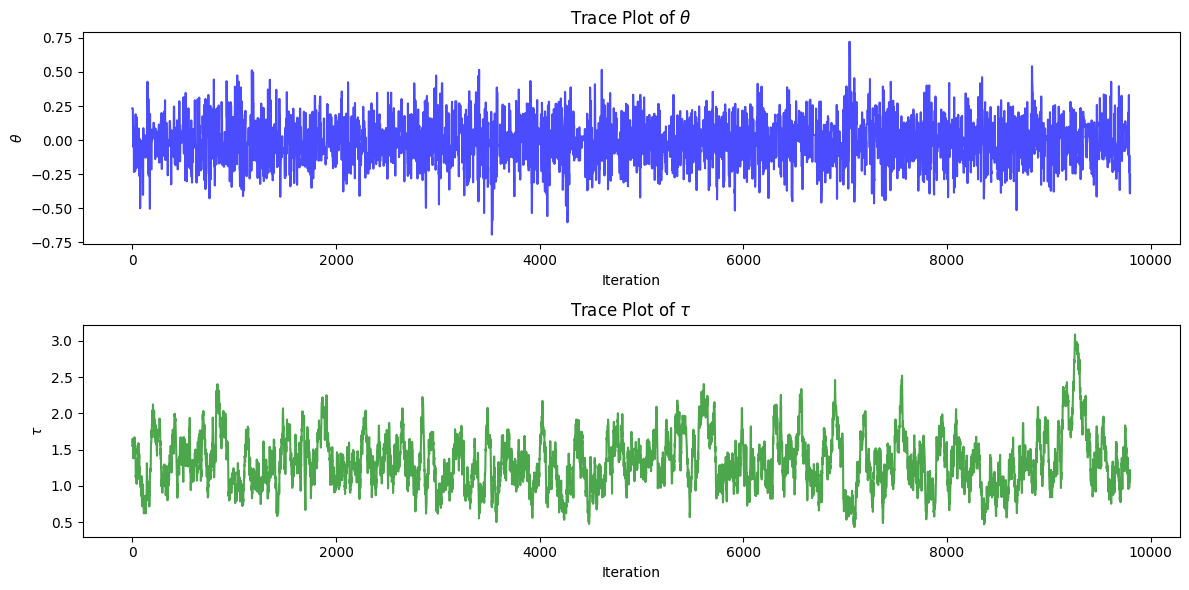

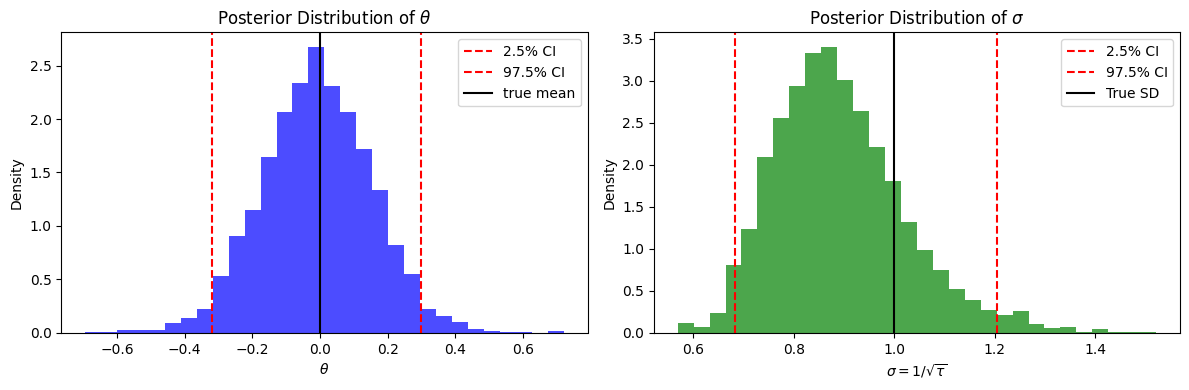

Theta credible interval: [-0.32063834  0.30031333]
Tau (converted to sigma) credible interval: [0.68311172 1.20515778]


In [12]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set parameters
n = 30
m = 0
s = 1
np.random.seed(365)
x = stats.norm(loc=m, scale=s).rvs(size=n)

C, G = 2, 10000  # Number of chains and iterations
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = np.mean(x)  # Initialize theta close to sample mean
tau[:, 0] = 1 / np.var(x)  # Initialize tau close to sample precision
alpha, lambda_ = 2, 2  # Prior hyperparameters

# Proposal standard deviations
theta_proposal_sd = 0.5  
tau_proposal_sd = 0.1  

# Metropolis within Gibbs Sampling
for c in range(C):
    for g in range(1, G):
        # 1. Metropolis step for theta
        theta_candidate = stats.norm(loc=theta[c, g - 1], scale=theta_proposal_sd).rvs()
        
        # Compute the acceptance ratio (log-scale for stability)
        log_posterior_current = (
            np.sum(stats.norm.logpdf(x, loc=theta[c, g - 1], scale=1 / np.sqrt(tau[c, g - 1])))
            + stats.norm.logpdf(theta[c, g - 1], loc=m, scale=s)
        )
        log_posterior_candidate = (
            np.sum(stats.norm.logpdf(x, loc=theta_candidate, scale=1 / np.sqrt(tau[c, g - 1])))
            + stats.norm.logpdf(theta_candidate, loc=m, scale=s)
        )
        
        log_alpha = log_posterior_candidate - log_posterior_current
        if np.log(np.random.rand()) < log_alpha:
            theta[c, g] = theta_candidate  # Accept
        else:
            theta[c, g] = theta[c, g - 1]  # Reject, keep previous value
        
        # 2. Metropolis step for tau (ensuring positivity)
        tau_candidate = abs(stats.norm(loc=tau[c, g - 1], scale=tau_proposal_sd).rvs())  # Using absolute value to keep positive
        
        log_posterior_current = (
            np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau[c, g - 1])))
            + stats.gamma.logpdf(tau[c, g - 1], a=alpha/2, scale=2/lambda_)
        )
        log_posterior_candidate = (
            np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau_candidate)))
            + stats.gamma.logpdf(tau_candidate, a=alpha/2, scale=2/lambda_)
        )
        
        log_alpha = log_posterior_candidate - log_posterior_current
        if np.log(np.random.rand()) < log_alpha:
            tau[c, g] = tau_candidate  # Accept
        else:
            tau[c, g] = tau[c, g - 1]  # Reject, keep previous value

# Burn-in period
burn = 200

# Compute Bayesian credible intervals
theta_samples = theta[0, burn:]
tau_samples = tau[0, burn:]

theta_ci = np.quantile(theta_samples, [0.025, 0.975])
tau_ci = np.quantile(1 / np.sqrt(tau_samples), [0.025, 0.975])

# Compute means
theta_mean = np.mean(theta_samples)
tau_mean = np.mean(1 / np.sqrt(tau_samples))

# Trace plots for theta and tau
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Trace plot for theta
ax[0].plot(theta[0, burn:], color='blue', alpha=0.7)
ax[0].set_title("Trace Plot of $\\theta$")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\\theta$")

# Trace plot for tau
ax[1].plot(tau[0, burn:], color='green', alpha=0.7)
ax[1].set_title("Trace Plot of $\\tau$")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$\\tau$")

plt.tight_layout()
plt.show()

# Plot histograms with credible intervals
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Theta histogram
ax[0].hist(theta_samples, bins=30, density=True, alpha=0.7, color='blue')
ax[0].axvline(theta_ci[0], color='red', linestyle='dashed', label="2.5% CI")
ax[0].axvline(theta_ci[1], color='red', linestyle='dashed', label="97.5% CI")
ax[0].axvline(m, color='black', linestyle='solid', label="true mean")
ax[0].set_title("Posterior Distribution of $\\theta$")
ax[0].set_xlabel("$\\theta$")
ax[0].set_ylabel("Density")
ax[0].legend()

# Tau (converted to standard deviation) histogram
ax[1].hist(1 / np.sqrt(tau_samples), bins=30, density=True, alpha=0.7, color='green')
ax[1].axvline(tau_ci[0], color='red', linestyle='dashed', label="2.5% CI")
ax[1].axvline(tau_ci[1], color='red', linestyle='dashed', label="97.5% CI")
ax[1].axvline(s, color='black', linestyle='solid', label="True SD")
ax[1].set_title("Posterior Distribution of $\\sigma$")
ax[1].set_xlabel("$\\sigma = 1 / \\sqrt{\\tau}$")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.show()

# Print credible intervals
print("Theta credible interval:", theta_ci)
print("Tau (converted to sigma) credible interval:", tau_ci)

### Question 2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

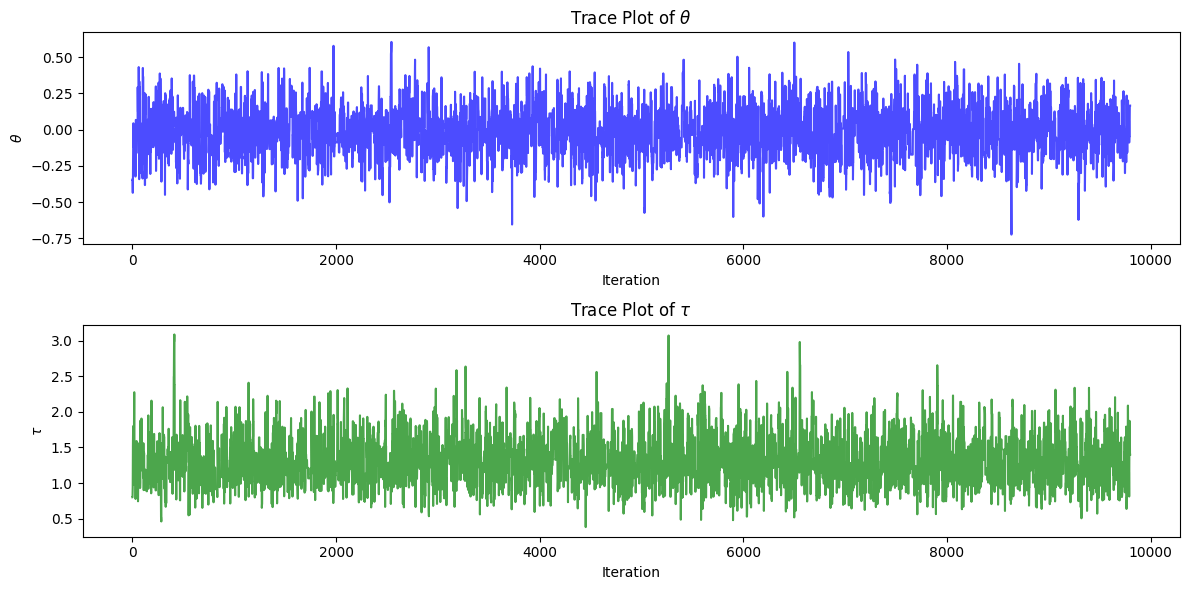

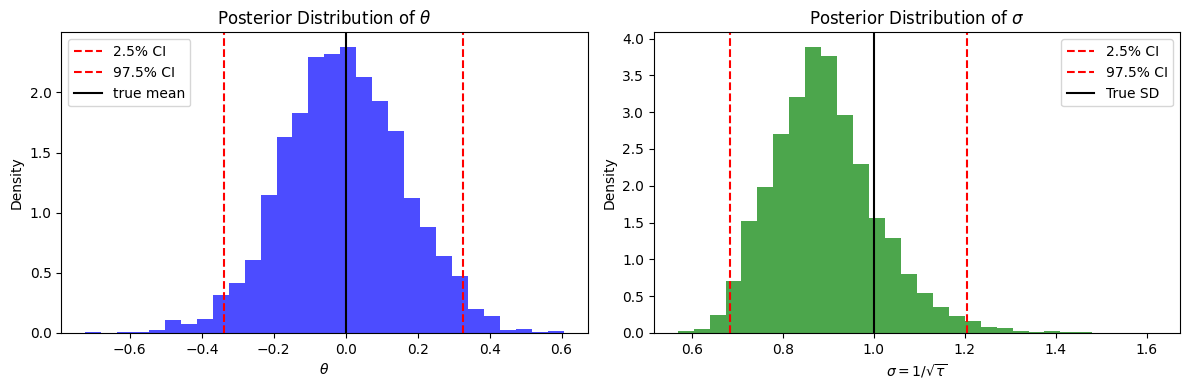

Theta credible interval: [-0.33848182  0.32459726]
Sigma credible interval: [0.6987826  1.15335167]


In [17]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters
n = 30
m = 0
s = 1
np.random.seed(365)
x = stats.norm(loc=m, scale=s).rvs(size=n)

C, G = 2, 10000  # Number of chains and iterations
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = np.mean(x)  # Initialize theta close to sample mean
tau[:, 0] = 1 / np.var(x)  # Initialize tau close to sample precision
alpha, lambda_ = 2, 2  # Prior hyperparameters

# Proposal standard deviation for theta
theta_proposal_sd = 0.5  

# Metropolis within Gibbs Sampling with Adjustments
for c in range(C):
    for g in range(1, G):
        # 1. Metropolis step for theta (Uniform prior)
        theta_candidate = stats.norm(loc=theta[c, g - 1], scale=theta_proposal_sd).rvs()

        if -5 <= theta_candidate <= 5:  # Uniform prior support
            log_posterior_current = np.sum(stats.norm.logpdf(x, loc=theta[c, g - 1], scale=1 / np.sqrt(tau[c, g - 1])))
            log_posterior_candidate = np.sum(stats.norm.logpdf(x, loc=theta_candidate, scale=1 / np.sqrt(tau[c, g - 1])))

            log_alpha = log_posterior_candidate - log_posterior_current
            if np.log(np.random.rand()) < log_alpha:
                theta[c, g] = theta_candidate  # Accept
            else:
                theta[c, g] = theta[c, g - 1]  # Reject, keep previous value
        else:
            theta[c, g] = theta[c, g - 1]  # Reject if outside uniform prior range

        # 2. Dependent proposal for tau (Truncated Normal)
        tau_t_minus_1 = tau[c, g - 1]
        tau_candidate = stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf, loc=tau_t_minus_1, scale=s).rvs()

        log_posterior_current = (
            np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau[c, g - 1])))
            + stats.gamma.logpdf(tau[c, g - 1], a=alpha/2, scale=2/lambda_)
        )
        log_posterior_candidate = (
            np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau_candidate)))
            + stats.gamma.logpdf(tau_candidate, a=alpha/2, scale=2/lambda_)
        )

        log_alpha = log_posterior_candidate - log_posterior_current
        if np.log(np.random.rand()) < log_alpha:
            tau[c, g] = tau_candidate  # Accept
        else:
            tau[c, g] = tau[c, g - 1]  # Reject, keep previous value

# Burn-in period
burn = 200

# Extract posterior samples after burn-in
theta_samples = theta[0, burn:]
tau_samples = tau[0, burn:]

# Convert tau to standard deviation (sigma)
sigma_samples = 1 / np.sqrt(tau_samples)

# Compute Bayesian credible intervals
theta_ci = np.quantile(theta_samples, [0.025, 0.975])
sigma_ci = np.quantile(sigma_samples, [0.025, 0.975])

# Compute means
theta_mean = np.mean(theta_samples)
sigma_mean = np.mean(sigma_samples)

# Trace plots for theta and tau
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(theta_samples, color='blue', alpha=0.7)
ax[0].set_title("Trace Plot of $\\theta$")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\\theta$")

ax[1].plot(tau_samples, color='green', alpha=0.7)
ax[1].set_title("Trace Plot of $\\tau$")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$\\tau$")

plt.tight_layout()
plt.show()

# Plot histograms with credible intervals
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Theta histogram
ax[0].hist(theta_samples, bins=30, density=True, alpha=0.7, color='blue')
ax[0].axvline(theta_ci[0], color='red', linestyle='dashed', label="2.5% CI")
ax[0].axvline(theta_ci[1], color='red', linestyle='dashed', label="97.5% CI")
ax[0].axvline(m, color='black', linestyle='solid', label="true mean")
ax[0].set_title("Posterior Distribution of $\\theta$")
ax[0].set_xlabel("$\\theta$")
ax[0].set_ylabel("Density")
ax[0].legend()

# Tau (converted to standard deviation) histogram
ax[1].hist(1 / np.sqrt(tau_samples), bins=30, density=True, alpha=0.7, color='green')
ax[1].axvline(tau_ci[0], color='red', linestyle='dashed', label="2.5% CI")
ax[1].axvline(tau_ci[1], color='red', linestyle='dashed', label="97.5% CI")
ax[1].axvline(s, color='black', linestyle='solid', label="True SD")
ax[1].set_title("Posterior Distribution of $\\sigma$")
ax[1].set_xlabel("$\\sigma = 1 / \\sqrt{\\tau}$")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.show()

# Print credible intervals
print("Theta credible interval:", theta_ci)
print("Sigma credible interval:", sigma_ci)